In [1]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re
import numpy as np
from shutil import copyfile, rmtree
from datetime import datetime
from fuzzywuzzy import process

# IMAGE IMPORTS
# from PIL import Image

# GIS IMPORTS
from affinetransformation import *
from affine import Affine
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point, MultiPoint, box
import rasterio as rio
import contextily as cx

# IMAGE IMPORTS
from skimage.morphology import skeletonize
from skimage import img_as_bool, img_as_ubyte


# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

%matplotlib widget

In [2]:
input_dir = r"D:\RECTDNN\uncompress\\"
proc_dir  = r"D:\RECTDNN\processing\2024-05-31_14-05-48\Tiles\\"

In [3]:
stateplanes = gpd.read_file(f"{data_dir}/AAA_ReferenceDatasets/stateplane.shp")
init_databases(f"{data_dir}/AAA_ReferenceDatasets/")

True

In [4]:
# LIST ALL IMAGES IN DIRECTORY
image_files = glob.glob(f"{input_dir}/*480287*")
image_files = [f for f in image_files if 'w' not in os.path.splitext(f)[1]]

# FILTER IMAGES USING HEURISTICS TO GET TILEINDICES
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(input_dir + "\\*" + pattern + "*.*[!w]*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)

# GET ACTUAL TILES
tiles       = list(set(image_files) - set(index_files))
tiles_bns   = [os.path.basename(tile).split(".")[0] for tile in tiles]

with open(f"{data_dir}/AAA_ReferenceDatasets/IndexCoords.pkl", 'rb') as handle:
    dict = pickle.load(handle)

We create the tile database with the detected tiles

In [5]:
duplicate_db, non_dupped_dict, dupped_dict = buildDetectedDatabase(dict)

print(len(non_dupped_dict), len(dupped_dict))  

detected_tiles = pd.DataFrame.from_dict(non_dupped_dict).T
detected_tiles['geometry'] = detected_tiles['coords'].apply(bbox_to_polygon)
detected_tiles_gdf = gpd.GeoDataFrame(detected_tiles)
detected_tiles_gdf = detected_tiles_gdf[['geometry']]

2190 1493


Here we supplement that database with all existing world files...

In [6]:
fn = os.path.join(proc_dir, "WorldFileDatabase.feather")
if os.path.exists(fn):
    df = pd.read_pickle(fn)
else:
    df = buildWorldFileDatabase(input_dir, duplicate_db, stateplanes)
    df.to_pickle(fn)

Now we can save both databases as shapefiles

In [7]:
# Apply the function to the 'bbox' column
df['geometry'] = df['webmerc'].apply(bbox_to_polygon)
gdf = gpd.GeoDataFrame(df)
gdf.dropna(axis=0)

for key in gdf.keys():
    if key == 'geometry':
        continue
    gdf[key] = gdf[key].astype(str)

gdf.to_file(r"D:\RECTDNN\WorldFiles.shp")
detected_tiles_gdf.to_file(r"D:\RECTDNN\Detected.shp")

This is where we identify Street Corners in each raster using YOLO models

In [8]:
FANN_prior = None
RLNN_prior = None
model = None

color=False

plot_params = {"labels" : False, }
YOLO_params = {
    "device"  : "cuda",     "find_text" : False, 
    "keyed_text"  : False,  "verbose" : False,  "get_data"  : False,
    "target_size" : 1920,   "plot_params" : plot_params, "ret_values" : True
}

# IF WE'VE ALREADY STARTED PROCESSING THINGS, LOAD STATE DICT
if os.path.exists(f'{proc_dir}results.pkl'):
    print("FOUND DICTIONARY, LOADING")
    with open(f'{proc_dir}results.pkl', 'rb') as handle:
        results_struct = pickle.load(handle)
else:
    results_struct = {}

# LOOP FOR EACH TILE
for i, tile in tqdm(enumerate(tiles), total=len(tiles)):
    
    # DEFINE WHERE GEOREFERENCED TILE IS SAVED
    out_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_FANN.png")
    fin_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_results.pkl")

    # HAVE WE ALREADY PROCESSED THIS TILE? IF SO, SKIP
    if results_struct.get(tile, None):
        # print(f"Found in dict, skipping {tile}")
        continue

    # WHICH VERSION OF FANN ARE WE USING
    if color:
        # RUN AND SAVE PREPROCESSING FANN AND RLNN
        prepped_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_prepped.png")                      # FILE NAME
        prepped, FANN_prior, RLNN_prior, bounds = findStreetCorners_colorPrep(tile, FANN=FANN_prior, RLNN=RLNN_prior)   # RUN FANN_PRIOR AND RLNN
        Image.fromarray(prepped).save(prepped_fn) # SAVE

        # RUN FANN
        results, model, base = runYOLO_Text(prepped_fn, model=model, model_weights=f"{data_dir}FANN/YOLO/051624.pt", **YOLO_params)
        
    else:
        bounds = None

        # RUN FANN
        results, model, base = runYOLO_Text(tile, model=model, model_weights=f"{data_dir}FANN/YOLO/051624_bw.pt", **YOLO_params)

    results_struct[tile] = results

    ''' IF YOU WANT TO SAVE DETAILED OUTPUT, THIS CODE WORKS, BUT IT'S HELLA SLOW AND BURDENSOME
    temp_dict = {"results" : results, "bounds" : bounds, "results_2" : base}
    results_struct[tile] = fin_fn
    if os.path.exists(fin_fn):
        os.remove(fin_fn)
    with open(fin_fn, 'wb') as handle:
        pickle.dump(temp_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    '''

    
    # SAVE EVERY N ITERATIONS AND LAST
    if i % 60 == 0 or i == len(tiles) - 1:
        file_path = f'{proc_dir}results.pkl'
        if os.path.exists(file_path):
            os.remove(file_path)
        with open(file_path, 'wb') as handle:
            pickle.dump(results_struct, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

FOUND DICTIONARY, LOADING


  0%|          | 0/220 [00:00<?, ?it/s]

45


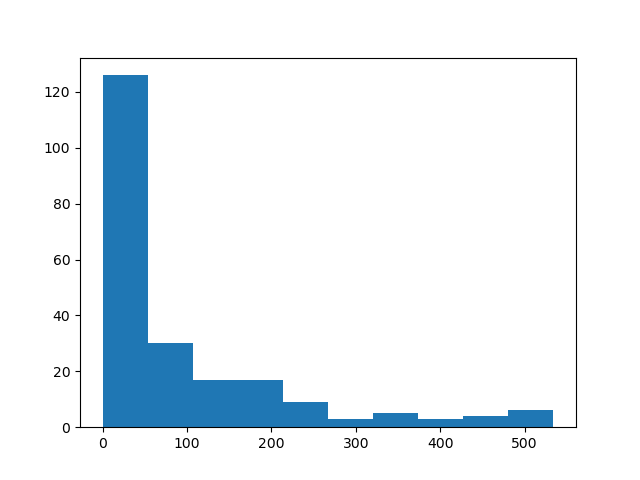

In [9]:
amount_of_corners = np.array([len(results_struct[list(results_struct.keys())[i]]) for i in range(len(results_struct))])
_ = plt.hist(amount_of_corners)
print(np.count_nonzero(amount_of_corners <= 10))

In [10]:
def bboxTransformToCRS(transform, image):
    rev_y_axis = np.array([[1, 0, 0],
                        [0,-1, 0],
                        [0, 0, 1]])
    
    translation = np.eye(3)
    translation[1, 2] = image.shape[0]

    return transform @ translation @ rev_y_axis


def bbox_to_coords_realworld(bbox):
    # BOUNDING BOX 

    x_min, y_min, x_max, y_max = bbox

    xs = [x_min, x_min, x_max, x_max]
    ys = [y_max, y_min, y_min, y_max]
    return xs, ys

def bbox_to_coords_raster(bbox):
    # BOUNDING BOX 

    x_min, y_min, x_max, y_max = bbox

    xs = [x_min, x_min, x_max, x_max]
    ys = [y_min, y_max, y_max, y_min]
    return xs, ys

bad = 0
RLNN = None

detected_tiles['reference_name'] = detected_tiles.index
list_tiles = list(detected_tiles_gdf.index)

tile_coords = {}
debug_struct = {}
for i, tile in tqdm(enumerate(tiles), total=len(tiles)):

    comp_length = len(tiles_bns[i]) - 2
    curr_tiles = [a if comp_length <= len(a) else "" for a in list_tiles]

    # KEEP NUMERIC PART OF TILE NAME
    p = re.sub(r"[^0-9]", "", os.path.basename(tile))
    
    # PERFORM MATCHING
    match, score = process.extractOne(tiles_bns[i], list_tiles)
    matches = process.extract(tiles_bns[i], curr_tiles)
    out_fn = os.path.join(proc_dir, tiles_bns[i] + ".tif")
    
    if score > 90:
        image = np.asarray(Image.open(tile))

        if np.max(image) < 255:
            image = image * 255
            image = image.astype(np.uint8)

        tile_coords[out_fn] = detected_tiles.loc[match]
        tile_coords[out_fn]['input_file'] = tile

        bounds, RLNN = findBounds(tile, RLNN)
        
        if len(bounds[0]) < 1:
            print(f"COULD NOT FIND BOUNDS, USING IMAGE EXTENTS {tile}")
            
            bbox = [0, 0, image.shape[0], image.shape[1]]
        else:
            bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()
        
        real_x, real_y = bbox_to_coords_realworld(tile_coords[out_fn]["coords"])
        pic_x, pic_y   = bbox_to_coords_raster(bbox)

        # transform = similarityTransformation(pic_x, pic_y, real_x, real_y)
        affine = affineTransformation(pic_x, pic_y, real_x, real_y)
        transform = bboxTransformToCRS(affine.matrix, image)

        # print(*transform.flatten()[:6])

        debug_struct[out_fn] = {
            "match"  : match,  "basename" : tiles_bns[i],
            "matches": matches,
            "real_x" : real_x, "real_y" : real_y,
            "pic_x"  : pic_x,  "pic_y"  : pic_y,
            "affine" : affine, "transform" : transform
        }
        try:
            with rio.open(out_fn, 'w',
                driver='GTiff', count=1, dtype=image.dtype,
                height=image.shape[0], width=image.shape[1],
                crs=f'EPSG:3857',
                transform=rio.Affine(*transform.flatten()[:6])) as dst:
                    dst.write(image, 1) 
        except: 
            print(f"Could not save {tiles_bns[i]}")
                
    else:
        tile_coords[out_fn] = None
        bad = bad + 1

  0%|          | 0/220 [00:00<?, ?it/s]

COULD NOT FIND BOUNDS, USING IMAGE EXTENTS D:\RECTDNN\uncompress\4802870260E.jpg


In [19]:
intersections = gpd.read_file(f"{data_dir}/AAA_ReferenceDatasets/Intersections.gpkg", engine='pyogrio', use_arrow=True)
# roads_gdf = gpd.read_file(r"C:\Users\fhacesga\Downloads\TxDOT_Street_Definition_-1346186713652838562\TxDOT_Street_Definition.shp", engine='pyogrio', use_arrow=True)
roads_gdf = gpd.read_file(r"C:\Users\fhacesga\Downloads\TexasRoads_filtered_3857.gpkg", engine='pyogrio', use_arrow=True)

In [20]:
def getRoadPoints(gdf, distance):
    """
    GENERATED WITH CHATGPT
    Interpolate points along the LineString geometries at every `distance` interval.
    
    Parameters:
    gdf (GeoDataFrame): A GeoDataFrame containing LineString geometries.
    distance (float): The distance interval at which to interpolate points.
    
    Returns:
    GeoDataFrame: A GeoDataFrame with the interpolated Point geometries.
    """
    points = []

    # Efficiently process LineStrings only
    for line in gdf.geometry:
        if line.geom_type == 'LineString':
            num_points = int(line.length // distance) + 1
            distances = [i * distance for i in range(num_points)]
            points.extend([line.interpolate(d) for d in distances])

    # Create a new GeoDataFrame with Point geometries
    points_gdf = gpd.GeoDataFrame(geometry=points, crs=gdf.crs)
    
    return points_gdf

  0%|          | 0/4 [00:00<?, ?it/s]

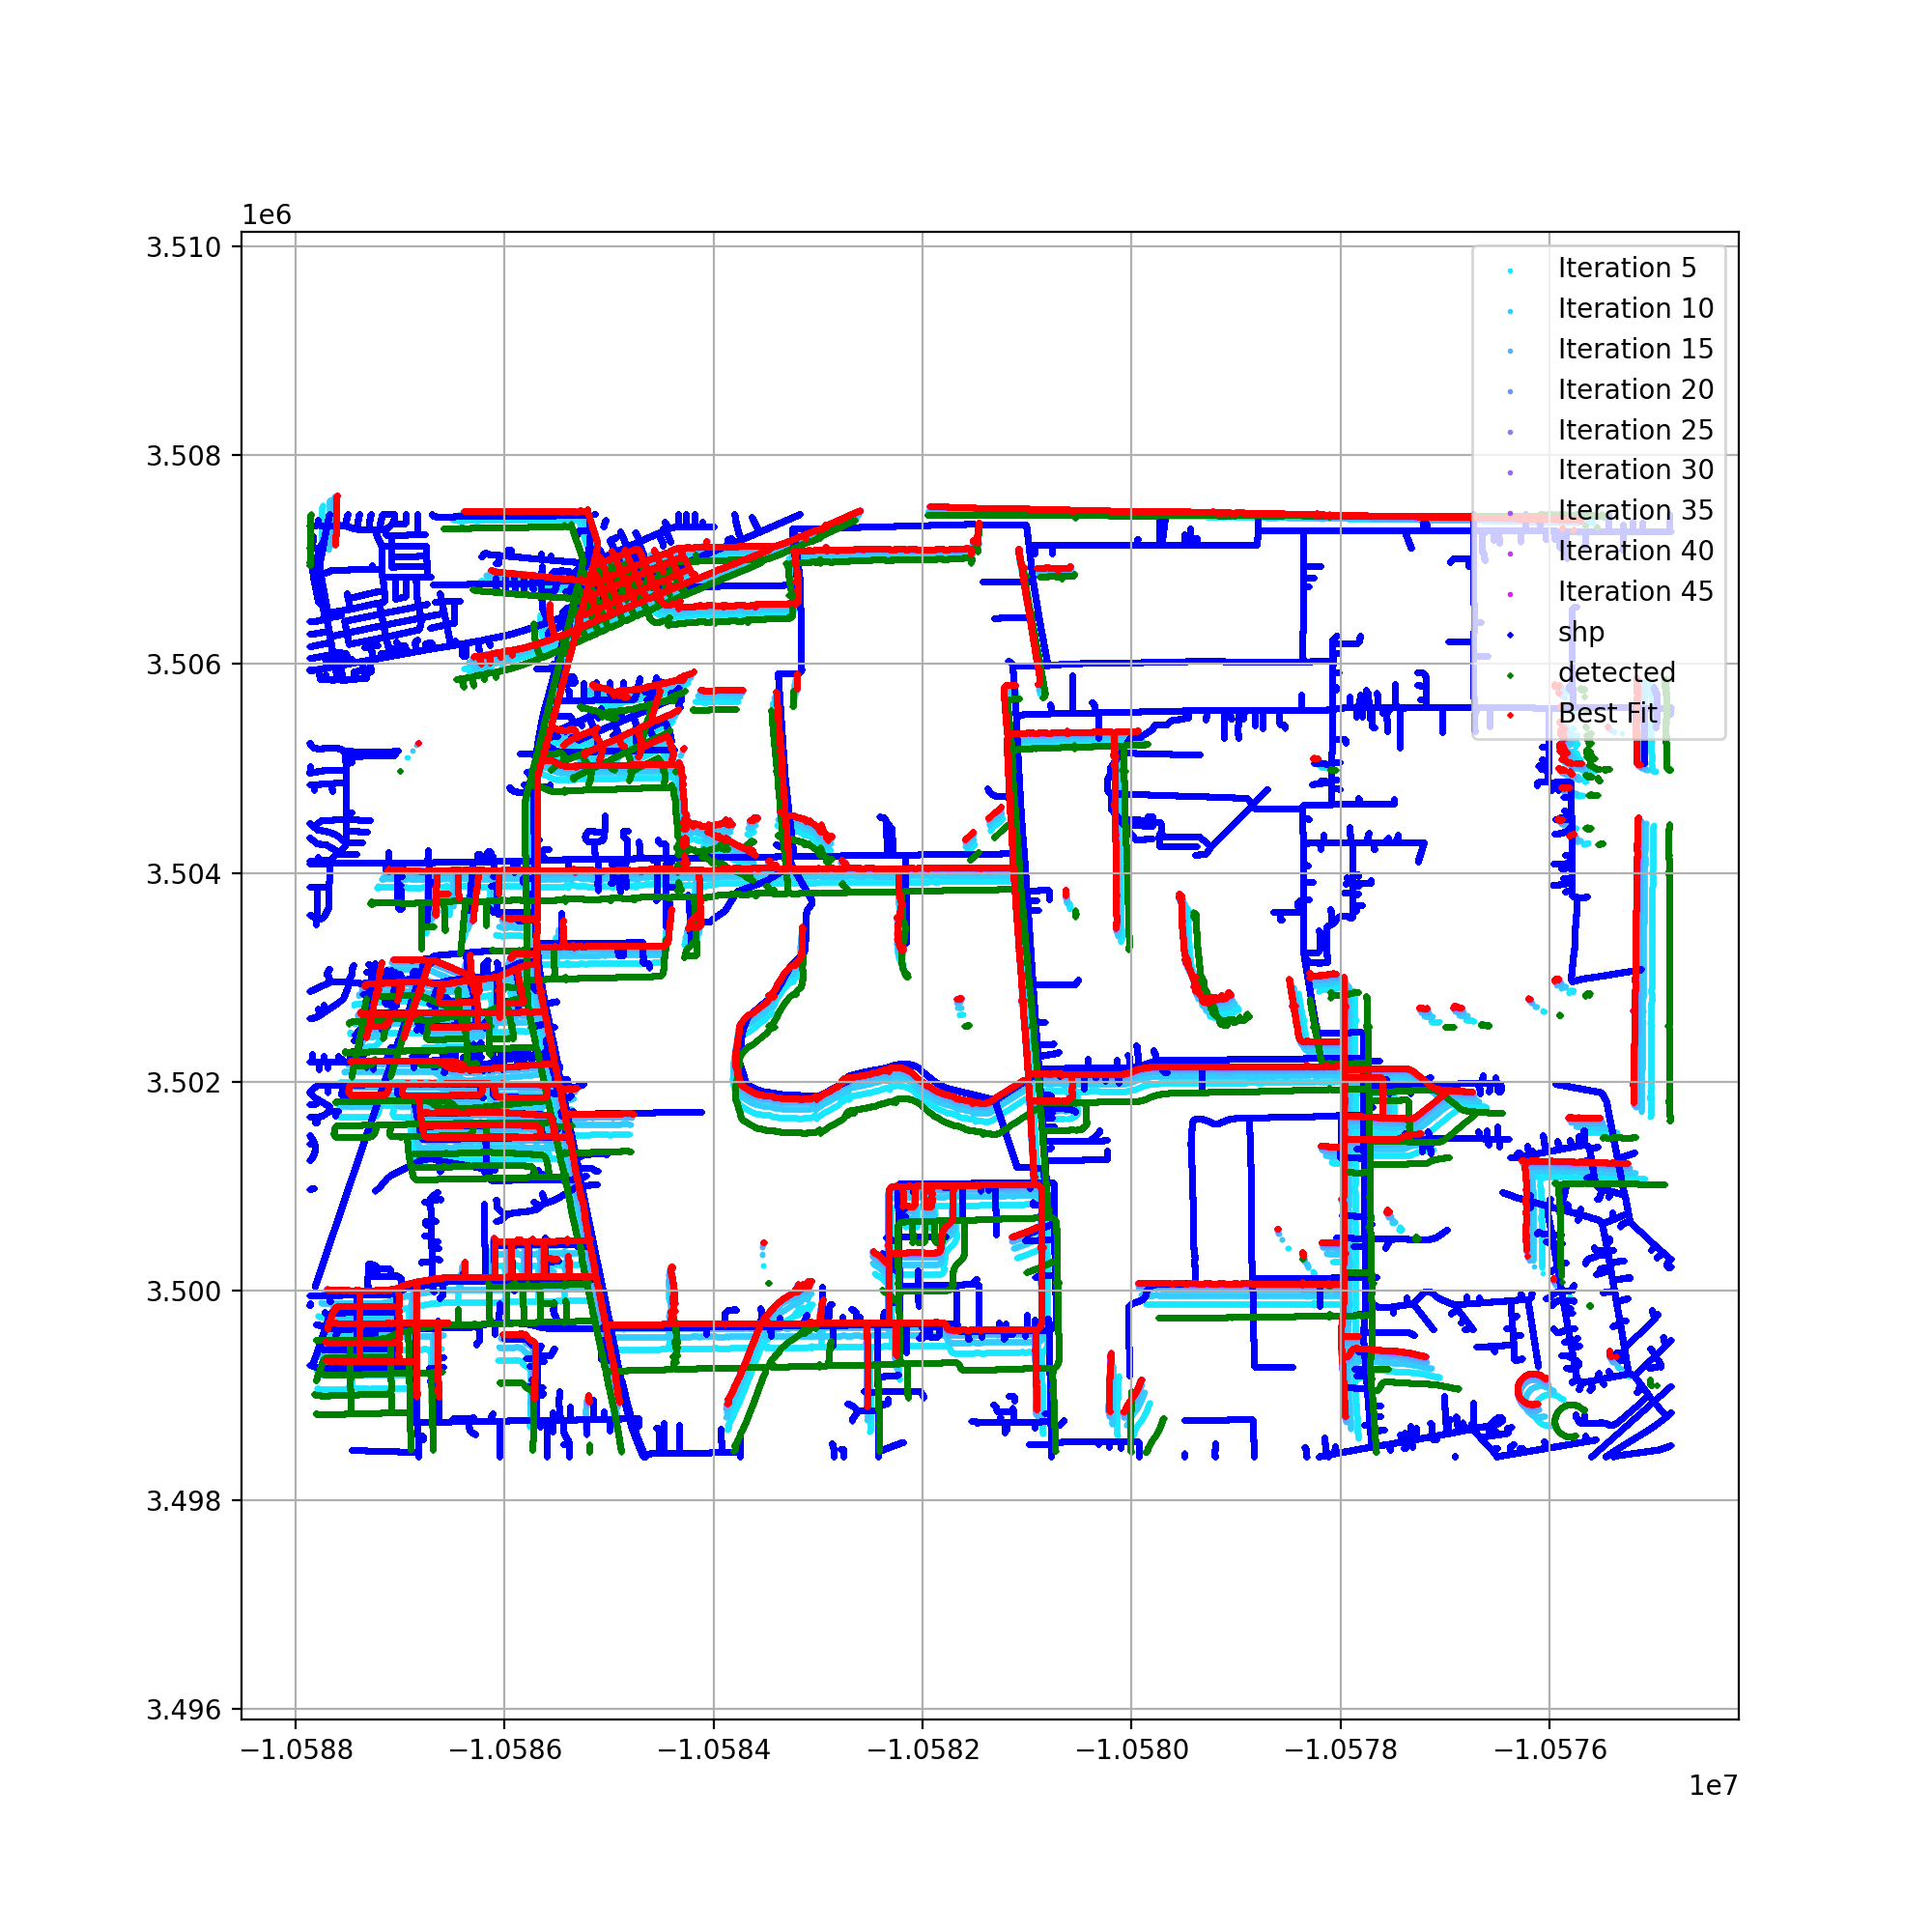

NameError: name 'error' is not defined

In [21]:
def calcCenter(a):
    # print(a,  (a[0] + a[2]) / 2, (a[1] + a[3]) / 2)
    return (a[0] + a[2]) / 2, (a[1] + a[3]) / 2

bestgrades = []
numcorners = []

model = TPNN(num_classes=2, finalpadding=1, inputsize=2)
checkpoint = torch.load(r'C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data/FANN/checkpoint_101123.pth')
model.load_state_dict(checkpoint['model_state_dict'])

for i, (out_name, db) in enumerate(tile_coords.items()):
    if db is not None:
        
        # GET STREET CORNERS FROM TPNN OUTPUTS
        street_corners = results_struct[tile_coords[out_name]['input_file']]

        # SKIP IF TOO FEW CORNERS
        if len(street_corners) < 3:
            continue

        # OPEN RASTER AND GET BOUNDING BOX
        ra = rio.open(out_name)
        bounds  = ra.bounds
        image   = ra.read(1)

        # RUN ROADS DETECTION ON CNN
        roads, _    = split_and_run_cnn(image, model, tilesize=1024, num_dim=3, edges=0, dims_rep=None, n_pyramids=2, device="cpu", verbose=True)
        roads_thin  = skeletonize(roads[:, :, 1] > 0.95)
        y, x = np.where(roads_thin[:, :])  
        xs, ys = rio.transform.xy(ra.transform, y, x)

        xy = list(zip(xs, ys))
        points = MultiPoint(xy)
        detections = gpd.GeoDataFrame(index=[0], geometry=[points]).explode(ignore_index=False, index_parts=False)

        bounds_poly = enlarged_bounds(ra, n=1)
        roads_clipped = gpd.clip(roads_gdf, bounds_poly)
        streets = getRoadPoints(roads_clipped, 0.5)

        ICP_fn = os.path.join(proc_dir, os.path.basename(out_name).split(".")[0] + "_ICP.tif")
        # best_transform, transform_dict = performICPonTile(detections, streets, plot=True, save_fig=ICP_fn, icp_iterations=500, conv=1e-6)
        best_transform, transform_dict = performICPonTile(detections, streets, plot=True, icp_iterations=50, conv=1e-6, rotation_limit=20)
        bestgrades.append(np.min(transform_dict['grades']))

        raster_name = os.path.join(proc_dir, os.path.basename(out_name).split(".")[0] + "_registered1.tif")
        transform = best_transform @ getMatrixFromAffine(ra.transform) 
        
        shp_name = os.path.join(proc_dir, os.path.basename(out_name).split(".")[0] + "_XY.gpkg")
        a = gpd.GeoDataFrame(crs="EPSG:3857", geometry=gpd.points_from_xy(transform_dict['reproj'][0][:, 0], transform_dict['reproj'][0][:, 1]))
        a.to_file(shp_name)

        try:
            with rio.open(raster_name, 'w',
                driver='GTiff', count=3, dtype=image.dtype,
                height=image.shape[0], width=image.shape[1],
                crs=f'EPSG:3857',
                transform=rio.Affine(*transform.flatten()[:6])) as dst:
                    dst.write(image, 1) 
                    dst.write(roads[:, :, 1] * 255, 2) 
                    dst.write(roads_thin, 3) 
        except:
             print(f"Could not save photo {out_name}")

        error

In [22]:
transform_dict['grades']

[179.0417650690432,
 174.23039939350932,
 170.86550108907434,
 167.91457934996015,
 165.1262787682464,
 162.45166500045724,
 159.8842651863009,
 157.54542689669643,
 155.74521359195566,
 154.30164131913725,
 152.90894043587653,
 151.63237090637733,
 150.5513563544805,
 149.5897542808315,
 148.5617506381877,
 147.88285332761458,
 147.48979185019314,
 147.25775987908702,
 147.12272277095403,
 147.0348352173519,
 146.985138311258,
 146.95528701060314,
 146.93721454765512,
 146.92472846506467,
 146.9163856997079,
 146.9108961618249,
 146.90690445042236,
 146.90428205769874,
 146.90200578794432,
 146.90048480841364,
 146.8993751056727,
 146.89857331374427,
 146.89807894224646,
 146.8977189668142,
 146.8973785197881,
 146.89709489700704,
 146.89698887571885,
 146.89688373860864,
 146.89680120675615,
 146.89672196418093,
 146.8966314081369,
 146.89654063531464,
 146.89649379896886,
 146.89645957239355,
 146.89641243934057,
 146.89636083381734,
 146.89631926974508,
 146.89627873189826,
 146.89

In [23]:
raster_name

'D:\\RECTDNN\\processing\\2024-05-31_14-05-48\\Tiles\\\\4802870230D_registered1.tif'

In [14]:
with rio.open(raster_name, 'w',
                driver='GTiff', count=3, dtype=image.dtype,
                height=image.shape[0], width=image.shape[1],
                crs=f'EPSG:3857',
                transform=rio.Affine(*transform.flatten()[:6])) as dst:
                    dst.write(image, 1) 
                    dst.write(roads[:, :, 1] * 255, 2) 
                    dst.write(roads_thin * 255, 3) 

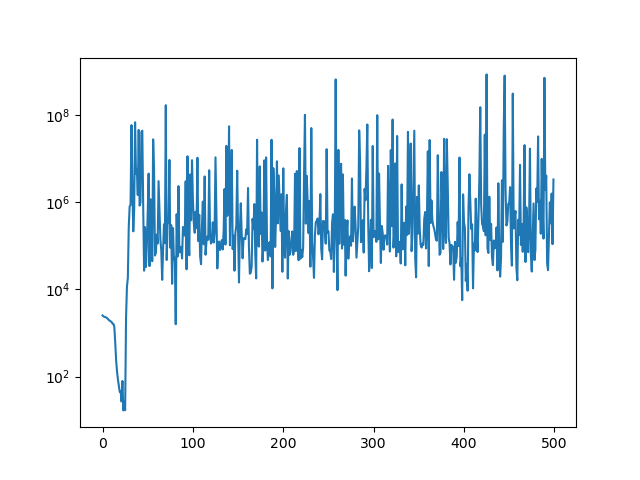

In [19]:
plt.figure()
plt.plot(transform_dict['grades'])
plt.yscale('log')

In [67]:
detections.to_file(r"C:\Users\fhacesga\Downloads\test.shp")

In [52]:
''' THE BELOW IS THE ORIGINAL ICP ON INTERSECTIONS
def calcCenter(a):
    # print(a,  (a[0] + a[2]) / 2, (a[1] + a[3]) / 2)
    return (a[0] + a[2]) / 2, (a[1] + a[3]) / 2

bestgrades = []
numcorners = []

for i, (out_name, db) in enumerate(tile_coords.items()):
    if db is not None:
        
        # GET STREET CORNERS FROM TPNN OUTPUTS
        street_corners = results_struct[tile_coords[out_name]['input_file']]

        # SKIP IF TOO FEW CORNERS
        if len(street_corners) < 3:
            continue

        # OPEN RASTER AND GET BOUNDING BOX
        ra = rio.open(out_name)
        bounds  = ra.bounds
        image   = ra.read(1)

        # CONVERT STREET CORNERS TO NUMPY ARRAY
        street_corners_arry = np.array([calcCenter(street_corners[a]['bbox']) for a in street_corners])
        streets = np.zeros(image.shape)
        streetcoords = np.int32(street_corners_arry)
        streets[streetcoords[:, 1], streetcoords[:, 0]] = 255

        # USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
        xs, ys = rio.transform.xy(ra.transform, street_corners_arry[:, 1], street_corners_arry[:, 0])
        numcorners.append(len(xs))
        print(out_name, len(xs))
        
        # GET IDENTIFIED STREET INTERSECTIONS
        xy = list(zip(xs, ys))
        points = MultiPoint(xy)
        TLNN = gpd.GeoDataFrame(index=[0], geometry=[points]).explode(ignore_index=False, index_parts=False)
        error
        # GET SHAPEFILE OF STREET INTERSECTIONS
        bounds_poly = enlarged_bounds(ra, n=1.5)
        STCN = gpd.clip(intersections, bounds_poly)

        ICP_fn = os.path.join(proc_dir, os.path.basename(out_name).split(".")[0] + "_ICP.tif")
        best_transform, transform_dict = performICPonTile(TLNN, STCN, plot=True, save_fig=ICP_fn, icp_iterations=500)
        bestgrades.append(np.min(transform_dict['grades']))

        raster_name = os.path.join(proc_dir, os.path.basename(out_name).split(".")[0] + "_registered.tif")
        transform = best_transform @ getMatrixFromAffine(ra.transform) 
        
        shp_name = os.path.join(proc_dir, os.path.basename(out_name).split(".")[0] + "_XY.gpkg")
        a = gpd.GeoDataFrame(crs="EPSG:3857", geometry=gpd.points_from_xy(transform_dict['reproj'][0][:, 0], transform_dict['reproj'][0][:, 1]))
        a.to_file(shp_name)

        try:
            with rio.open(raster_name, 'w',
                driver='GTiff', count=3, dtype=image.dtype,
                height=image.shape[0], width=image.shape[1],
                crs=f'EPSG:3857',
                transform=rio.Affine(*transform.flatten()[:6])) as dst:
                    dst.write(image, 1) 
                    dst.write(image, 2) 
                    dst.write(streets, 3) 
        except:
             print(f"Could not save photo {out_name}")
        error
'''

,geometry
0,POINT (-10645707.393 3512697.583)
0,POINT (-10645864.720 3512819.735)
0,POINT (-10646884.339 3512437.850)
0,POINT (-10645161.689 3512588.848)
0,POINT (-10646937.977 3515060.100)
...,...
0,POINT (-10646223.897 3516532.466)
0,POINT (-10645482.412 3514678.834)
0,POINT (-10648270.442 3514021.119)
0,POINT (-10647734.137 3516656.439)


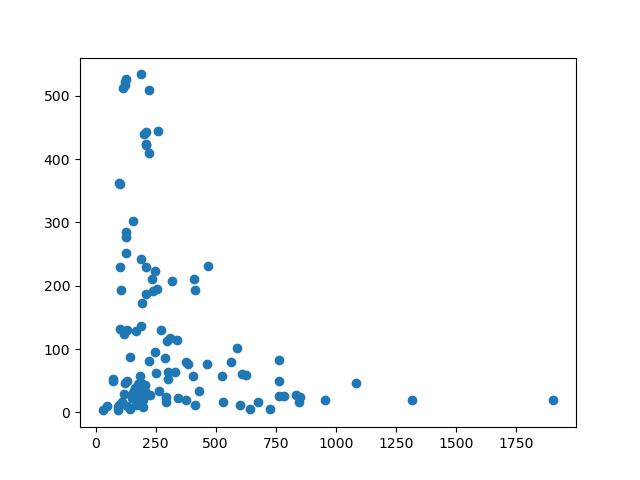

In [13]:
fig, ax = plt.subplots()
ax.scatter(bestgrades, numcorners)